In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [23]:
batch_size = 64
learning_rate = 0.0002
num_epochs = 50
latent_dim = 100  # Dimension of the noise vector


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.16MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)


In [7]:
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')


Epoch [1/50], Step [200/938], D Loss: 0.0565, G Loss: 3.3206, D(x): 1.00, D(G(z)): 0.05
Epoch [1/50], Step [400/938], D Loss: 0.2564, G Loss: 5.3968, D(x): 0.90, D(G(z)): 0.12
Epoch [1/50], Step [600/938], D Loss: 0.4116, G Loss: 2.7811, D(x): 0.74, D(G(z)): 0.09
Epoch [1/50], Step [800/938], D Loss: 1.1490, G Loss: 1.1380, D(x): 0.63, D(G(z)): 0.44
Epoch [2/50], Step [200/938], D Loss: 1.1067, G Loss: 0.8401, D(x): 0.77, D(G(z)): 0.52
Epoch [2/50], Step [400/938], D Loss: 1.1513, G Loss: 0.9662, D(x): 0.59, D(G(z)): 0.45
Epoch [2/50], Step [600/938], D Loss: 1.0867, G Loss: 3.2513, D(x): 0.57, D(G(z)): 0.27
Epoch [2/50], Step [800/938], D Loss: 1.4399, G Loss: 0.7926, D(x): 0.52, D(G(z)): 0.50
Epoch [3/50], Step [200/938], D Loss: 0.5021, G Loss: 2.0031, D(x): 0.80, D(G(z)): 0.18
Epoch [3/50], Step [400/938], D Loss: 0.1862, G Loss: 2.8658, D(x): 0.95, D(G(z)): 0.06
Epoch [3/50], Step [600/938], D Loss: 0.6124, G Loss: 1.4820, D(x): 0.77, D(G(z)): 0.25
Epoch [3/50], Step [800/938], D 

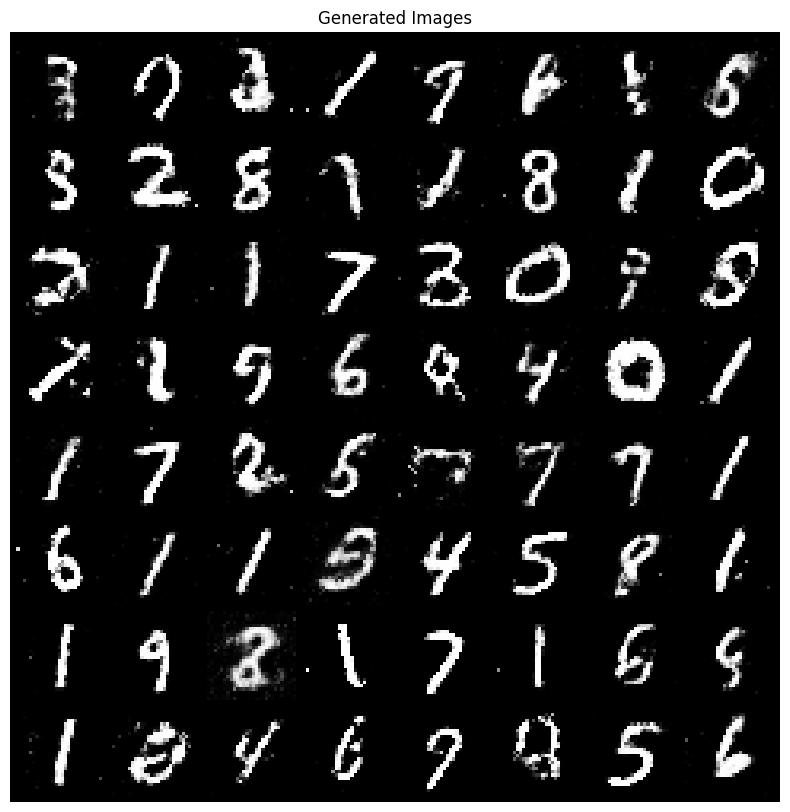

In [24]:
import matplotlib.pyplot as plt
noise = torch.randn(batch_size, latent_dim).to(device)
fake_images = generator(noise)
fake_images = fake_images.cpu().detach()

grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Generated Images')
plt.imshow(grid.permute(1, 2, 0))
plt.show()